# Skylark Labs: Machine Learning Engineer Assessment
## Activation Swap + Fine-Tuning Challenge

**Author:** Vedant Madane  
**Date:** September 12, 2025  
**Challenge:** ResNet activation replacement + CIFAR-10 multi-class classification

This notebook implements:
1. ResNet model with ReLU→SiLU activation swapping (from 7th occurrence)
2. CIFAR-10 subset classification (3 classes)
3. Training pipeline with full reproducibility
4. Performance evaluation and analysis

## 0) Setup & Reproducibility

In [1]:
# Core imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
import random
import time
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Reproducibility setup
SEED = 1337

def set_seeds(seed=SEED):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Additional reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(SEED)

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Environment summary
print("=== Environment Summary ===")
print(f"Python: {torch.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

print("\n=== Reproducibility Settings ===")
print(f"Fixed seed: {SEED}")
print(f"cudnn.deterministic: {torch.backends.cudnn.deterministic}")
print(f"cudnn.benchmark: {torch.backends.cudnn.benchmark}")

# Record start time
start_time = time.time()

=== Environment Summary ===
Python: 2.9.0+cu128
PyTorch: 2.9.0+cu128
Torchvision: 0.24.0+cu128
Device: cpu
CUDA available: False

=== Reproducibility Settings ===
Fixed seed: 1337
cudnn.deterministic: True
cudnn.benchmark: False


In [ ]:
# Installation note: torchvision (and torch) are already available in the notebook environment.
# If you need to (re)install packages in this kernel, run the following in a cell:
# import sys, subprocess
# subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torch torchvision'])


  Using cached torch-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torch-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached n

## 1) Model Architecture

### 1.1 Base Model Selection

In [2]:
# Load base model
model_name = 'resnet18'
pretrained = True

model = torchvision.models.resnet18(pretrained=pretrained)

print(f"Using {model_name}, pretrained={pretrained}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/usr/local/python/3.12.1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%
100.0%


Using resnet18, pretrained=True
Total parameters: 11,689,512
Trainable parameters: 11,689,512


**Model Choice Justification:**
- ResNet18 chosen for balance between capacity and training speed on CPU
- Pretrained weights provide good feature representations, reducing training time
- Suitable architecture for CIFAR-10's 32x32 resolution

### 1.2 Activation Function Replacement

In [3]:
def count_relu_modules(model):
    """Count all nn.ReLU modules in the model using depth-first traversal"""
    relu_count = 0
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            relu_count += 1
    return relu_count

def replace_relu_from_nth(model, n=7, replacement_activation=nn.SiLU):
    """
    Replace ReLU activations from the nth occurrence onward with replacement_activation
    
    Args:
        model: PyTorch model
        n: Starting position (1-based indexing)
        replacement_activation: New activation class (e.g., nn.SiLU, nn.GELU)
    
    Returns:
        List of indices (1-based) where replacements occurred
    """
    relu_counter = 0
    replaced_indices = []
    
    def replace_in_module(module, parent_name=""):
        nonlocal relu_counter
        
        for name, child in module.named_children():
            full_name = f"{parent_name}.{name}" if parent_name else name
            
            if isinstance(child, nn.ReLU):
                relu_counter += 1
                if relu_counter >= n:  # 1-based indexing
                    # Replace with new activation
                    setattr(module, name, replacement_activation())
                    replaced_indices.append(relu_counter)
                    print(f"  Replaced ReLU #{relu_counter} at {full_name}")
            else:
                replace_in_module(child, full_name)
    
    replace_in_module(model)
    return replaced_indices

# Count ReLUs before replacement
relu_count_before = count_relu_modules(model)
print(f"Total nn.ReLU before replacement: {relu_count_before}")

# Replace ReLU from 7th occurrence onward with SiLU
replacement_activation = nn.SiLU
print(f"\nReplacing activations from 7th occurrence onward with {replacement_activation.__name__}:")
replaced_indices = replace_relu_from_nth(model, n=7, replacement_activation=replacement_activation)
print(f"\nReplacing activations at indices (1-based): {replaced_indices}")

# Sanity check after replacement
relu_count_after = count_relu_modules(model)
silu_count = sum(1 for m in model.modules() if isinstance(m, nn.SiLU))

print(f"\n=== Post-replacement Verification ===")
print(f"ReLU remaining: {relu_count_after}")
print(f"SiLU inserted: {silu_count}")

# Assertion to verify correct replacement
expected_replacements = len(replaced_indices)
assert relu_count_before - relu_count_after == expected_replacements, "Replacement count mismatch!"
assert silu_count == expected_replacements, "SiLU count doesn't match replacements!"
print(f"✓ Assertion passed: Exactly {expected_replacements} activations replaced")

Total nn.ReLU before replacement: 9

Replacing activations from 7th occurrence onward with SiLU:
  Replaced ReLU #7 at layer3.1.relu
  Replaced ReLU #8 at layer4.0.relu
  Replaced ReLU #9 at layer4.1.relu

Replacing activations at indices (1-based): [7, 8, 9]

=== Post-replacement Verification ===
ReLU remaining: 6
SiLU inserted: 3
✓ Assertion passed: Exactly 3 activations replaced


### 1.3 Classification Head Modification

In [4]:
# CIFAR-10 class selection
N_CLASSES = 3
selected_classes = ['cat', 'dog', 'airplane']  # Original CIFAR-10 indices: [3, 5, 0]
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get original FC layer info
original_fc = model.fc
print(f"Old head shape: in_features={original_fc.in_features} → out_features={original_fc.out_features}")

# Replace final FC layer
model.fc = nn.Linear(original_fc.in_features, N_CLASSES)

print(f"New head shape: in_features={model.fc.in_features} → out_features={model.fc.out_features}")
print(f"Number of target classes: {N_CLASSES}")
print(f"Selected classes: {selected_classes}")

# Move model to device
model = model.to(device)
print(f"\nModel moved to: {device}")

Old head shape: in_features=512 → out_features=1000
New head shape: in_features=512 → out_features=3
Number of target classes: 3
Selected classes: ['cat', 'dog', 'airplane']

Model moved to: cpu


## 2) Data Pipeline

### 2.1 Dataset Preparation

In [5]:
def filter_dataset(dataset, target_classes, class_names):
    """
    Filter dataset to only include target classes and relabel them
    
    Args:
        dataset: CIFAR-10 dataset
        target_classes: List of class names to keep
        class_names: Full CIFAR-10 class names list
    
    Returns:
        Filtered indices and class mapping
    """
    # Get original class indices
    original_indices = [class_names.index(cls) for cls in target_classes]
    
    # Create mapping: original_label_id -> new_label_id
    label_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(original_indices)}
    class_name_mapping = {cls_name: new_idx for new_idx, cls_name in enumerate(target_classes)}
    
    # Filter dataset indices
    filtered_indices = []
    for idx, (_, label) in enumerate(dataset):
        if label in original_indices:
            filtered_indices.append(idx)
    
    return filtered_indices, label_mapping, class_name_mapping

class FilteredDataset:
    """Wrapper to apply filtering and relabeling"""
    def __init__(self, dataset, indices, label_mapping):
        self.dataset = dataset
        self.indices = indices
        self.label_mapping = label_mapping
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image, original_label = self.dataset[real_idx]
        new_label = self.label_mapping[original_label]
        return image, new_label

# Basic transforms for initial loading
basic_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 datasets
print("Downloading/Loading CIFAR-10...")
train_dataset_full = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=basic_transform
)
test_dataset_full = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=basic_transform
)

print(f"Full CIFAR-10 loaded: {len(train_dataset_full)} train, {len(test_dataset_full)} test")

# Filter datasets
train_indices, label_mapping, class_name_mapping = filter_dataset(
    train_dataset_full, selected_classes, cifar10_classes
)
test_indices, _, _ = filter_dataset(
    test_dataset_full, selected_classes, cifar10_classes
)

print(f"\n=== Dataset Filtering Results ===")
print(f"Selected classes: {selected_classes}")
print(f"Original label mapping: {label_mapping}")
print(f"Class name mapping: {class_name_mapping}")

# Create filtered datasets
train_dataset_filtered = FilteredDataset(train_dataset_full, train_indices, label_mapping)
val_dataset_filtered = FilteredDataset(test_dataset_full, test_indices, label_mapping)

# Count samples per class
def count_classes(dataset):
    """Count samples per class in dataset"""
    labels = [dataset[i][1] for i in range(len(dataset))]
    return Counter(labels)

train_counts = count_classes(train_dataset_filtered)
val_counts = count_classes(val_dataset_filtered)

print(f"\n=== Class Distribution ===")
print(f"Train counts: {dict(train_counts)}")
print(f"Val counts: {dict(val_counts)}")
print(f"Total train samples: {len(train_dataset_filtered)}")
print(f"Total val samples: {len(val_dataset_filtered)}")

# Verify we have all classes
assert len(train_counts) == N_CLASSES, f"Missing classes in train set: {train_counts}"
assert len(val_counts) == N_CLASSES, f"Missing classes in val set: {val_counts}"
assert min(train_counts.values()) > 0, "Zero samples in some train classes"
assert min(val_counts.values()) > 0, "Zero samples in some val classes"
print("✓ All classes present with non-zero samples")

Downloading/Loading CIFAR-10...


100.0%



Full CIFAR-10 loaded: 50000 train, 10000 test

=== Dataset Filtering Results ===
Selected classes: ['cat', 'dog', 'airplane']
Original label mapping: {3: 0, 5: 1, 0: 2}
Class name mapping: {'cat': 0, 'dog': 1, 'airplane': 2}

=== Dataset Filtering Results ===
Selected classes: ['cat', 'dog', 'airplane']
Original label mapping: {3: 0, 5: 1, 0: 2}
Class name mapping: {'cat': 0, 'dog': 1, 'airplane': 2}

=== Class Distribution ===
Train counts: {0: 5000, 1: 5000, 2: 5000}
Val counts: {0: 1000, 2: 1000, 1: 1000}
Total train samples: 15000
Total val samples: 3000
✓ All classes present with non-zero samples

=== Class Distribution ===
Train counts: {0: 5000, 1: 5000, 2: 5000}
Val counts: {0: 1000, 2: 1000, 1: 1000}
Total train samples: 15000
Total val samples: 3000
✓ All classes present with non-zero samples


### 2.2 Data Augmentation

In [6]:
# Define transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor back to PIL for augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

print("=== Transform Summary ===")
print("Train transforms:")
print("  - RandomCrop(32, padding=4)")
print("  - RandomHorizontalFlip(p=0.5)")
print("  - Normalization (CIFAR-10 stats)")
print("\nVal transforms:")
print("  - Center crop/resize (no augmentation)")
print("  - Normalization (CIFAR-10 stats)")

# Apply transforms to datasets
class TransformDataset:
    """Apply transforms to existing dataset"""
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            # Convert tensor to numpy for PIL conversion if needed
            if isinstance(image, torch.Tensor):
                image = (image * 255).byte()  # Convert to 0-255 range
            image = self.transform(image)
        return image, label

train_dataset = TransformDataset(train_dataset_filtered, train_transform)
val_dataset = TransformDataset(val_dataset_filtered, val_transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n=== DataLoader Info ===")
print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Sample batch shapes
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

print(f"\nTrain batch shape: {train_batch[0].shape}, labels: {train_batch[1].shape}")
print(f"Val batch shape: {val_batch[0].shape}, labels: {val_batch[1].shape}")

# Verify data range
print(f"\nData range verification:")
print(f"Train batch - min: {train_batch[0].min():.3f}, max: {train_batch[0].max():.3f}")
print(f"Val batch - min: {val_batch[0].min():.3f}, max: {val_batch[0].max():.3f}")
print(f"Unique train labels: {sorted(train_batch[1].unique().tolist())}")
print(f"Unique val labels: {sorted(val_batch[1].unique().tolist())}")

=== Transform Summary ===
Train transforms:
  - RandomCrop(32, padding=4)
  - RandomHorizontalFlip(p=0.5)
  - Normalization (CIFAR-10 stats)

Val transforms:
  - Center crop/resize (no augmentation)
  - Normalization (CIFAR-10 stats)

=== DataLoader Info ===
Batch size: 64
Train batches: 235
Val batches: 47

Train batch shape: torch.Size([64, 3, 32, 32]), labels: torch.Size([64])
Val batch shape: torch.Size([64, 3, 32, 32]), labels: torch.Size([64])

Data range verification:
Train batch - min: -2.429, max: 2.754
Val batch - min: -2.429, max: 2.754
Unique train labels: [0, 1, 2]
Unique val labels: [0, 1, 2]

Train batch shape: torch.Size([64, 3, 32, 32]), labels: torch.Size([64])
Val batch shape: torch.Size([64, 3, 32, 32]), labels: torch.Size([64])

Data range verification:
Train batch - min: -2.429, max: 2.754
Val batch - min: -2.429, max: 2.754
Unique train labels: [0, 1, 2]
Unique val labels: [0, 1, 2]


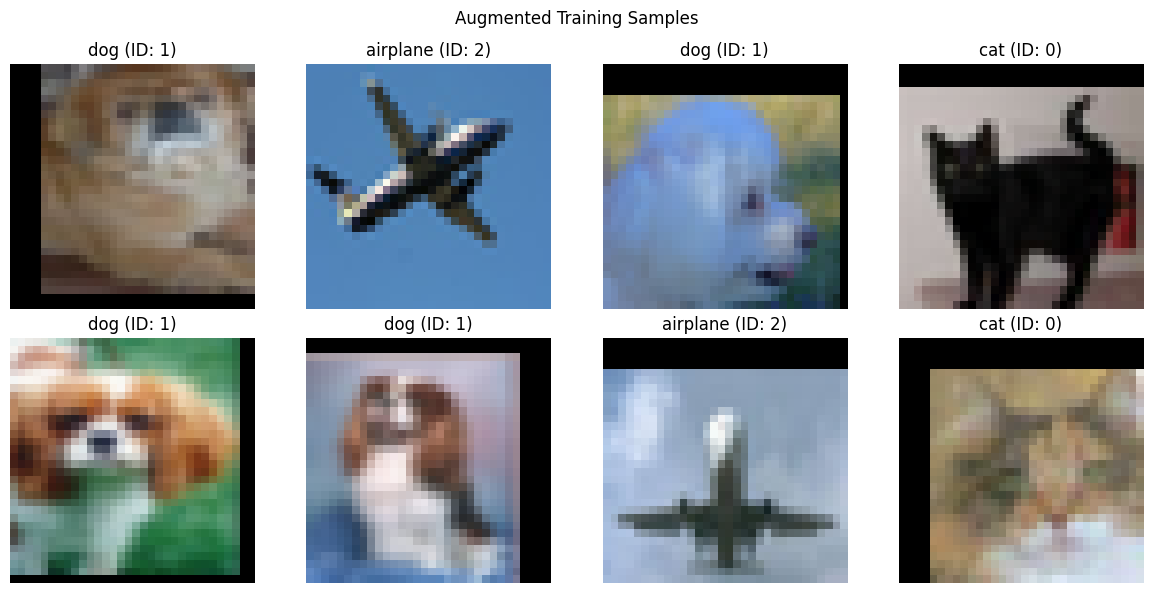

In [7]:
# Optional: Visualize augmented samples
def show_batch_samples(dataloader, class_names, title="Sample Images", n_samples=8):
    """Display a grid of sample images with their labels"""
    batch_images, batch_labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(min(n_samples, len(batch_images))):
        img = batch_images[i]
        label = batch_labels[i].item()
        
        # Denormalize image for display
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(-1, 1, 1)
        img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(-1, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"{class_names[label]} (ID: {label})")
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show augmented training samples
show_batch_samples(train_loader, selected_classes, "Augmented Training Samples", n_samples=8)

## 3) Training & Evaluation

### 3.1 Training Loop

In [8]:
# Training configuration
num_epochs = 10
learning_rate = 0.01
weight_decay = 1e-4

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(f"=== Training Configuration ===")
print(f"Epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {weight_decay}")
print(f"Optimizer: SGD with momentum=0.9")
print(f"Scheduler: StepLR (step_size=7, gamma=0.1)")
print(f"Criterion: CrossEntropyLoss")

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Training loop
print(f"\n=== Training Started ===")
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0
best_epoch = 0

training_start = time.time()

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Track metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
    
    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.1f}% | "
          f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.1f}%")

training_end = time.time()
training_time = training_end - training_start

print(f"\n=== Training Completed ===")
print(f"Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print(f"Best Val Acc: {best_val_acc:.1f}% (epoch {best_epoch})")

=== Training Configuration ===
Epochs: 10
Learning rate: 0.01
Weight decay: 0.0001
Optimizer: SGD with momentum=0.9
Scheduler: StepLR (step_size=7, gamma=0.1)
Criterion: CrossEntropyLoss

=== Training Started ===
Epoch 1/10 | Train Loss: 0.568 | Train Acc: 75.4% | Val Loss: 0.403 | Val Acc: 82.6%
Epoch 1/10 | Train Loss: 0.568 | Train Acc: 75.4% | Val Loss: 0.403 | Val Acc: 82.6%
Epoch 2/10 | Train Loss: 0.437 | Train Acc: 80.5% | Val Loss: 0.419 | Val Acc: 81.9%
Epoch 2/10 | Train Loss: 0.437 | Train Acc: 80.5% | Val Loss: 0.419 | Val Acc: 81.9%
Epoch 3/10 | Train Loss: 0.414 | Train Acc: 82.0% | Val Loss: 0.384 | Val Acc: 84.5%
Epoch 3/10 | Train Loss: 0.414 | Train Acc: 82.0% | Val Loss: 0.384 | Val Acc: 84.5%
Epoch 4/10 | Train Loss: 0.360 | Train Acc: 84.4% | Val Loss: 0.386 | Val Acc: 84.5%
Epoch 4/10 | Train Loss: 0.360 | Train Acc: 84.4% | Val Loss: 0.386 | Val Acc: 84.5%
Epoch 5/10 | Train Loss: 0.346 | Train Acc: 85.4% | Val Loss: 0.338 | Val Acc: 86.5%
Epoch 5/10 | Train Los

### 3.2 Performance Reporting

Final Val Acc: 87.6%

=== Confusion Matrix ===
         cat     dogairplane
 cat      821     156      23
 dog      153     833      14
airplane       24       3     973

=== Classification Report ===
              precision    recall  f1-score   support

         cat      0.823     0.821     0.822      1000
         dog      0.840     0.833     0.836      1000
    airplane      0.963     0.973     0.968      1000

    accuracy                          0.876      3000
   macro avg      0.875     0.876     0.875      3000
weighted avg      0.875     0.876     0.875      3000


=== Confusion Matrix ===
         cat     dogairplane
 cat      821     156      23
 dog      153     833      14
airplane       24       3     973

=== Classification Report ===
              precision    recall  f1-score   support

         cat      0.823     0.821     0.822      1000
         dog      0.840     0.833     0.836      1000
    airplane      0.963     0.973     0.968      1000

    accuracy        

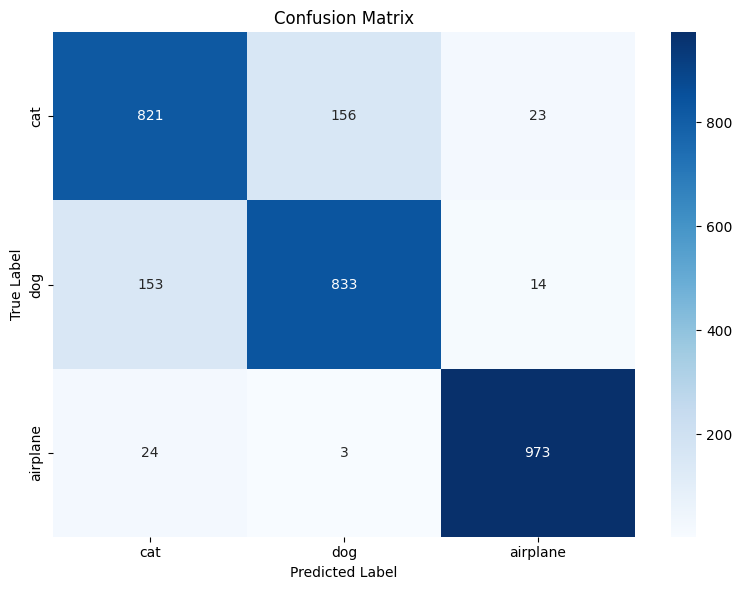

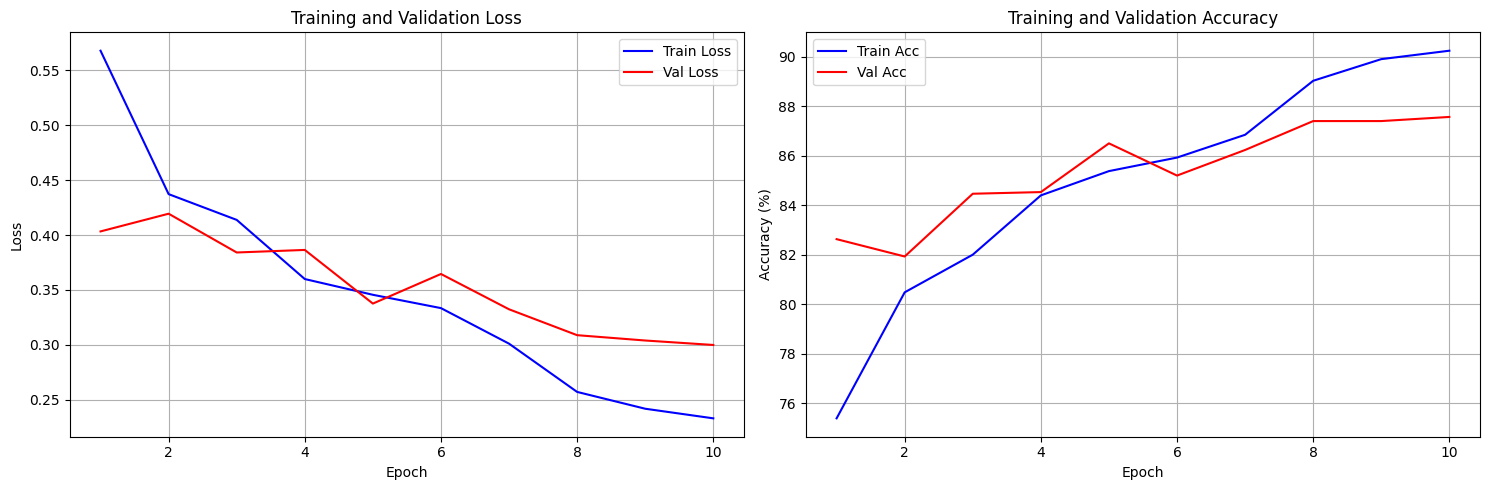

In [9]:
# Final validation evaluation
final_val_loss, final_val_acc = validate_epoch(model, val_loader, criterion, device)
print(f"Final Val Acc: {final_val_acc:.1f}%")

# Generate predictions for confusion matrix
def get_predictions(model, dataloader, device):
    """Get all predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.numpy())
    
    return np.array(all_preds), np.array(all_labels)

val_preds, val_labels = get_predictions(model, val_loader, device)

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
print(f"\n=== Confusion Matrix ===")
print("    ", end="")
for i, cls in enumerate(selected_classes):
    print(f"{cls:>8}", end="")
print()
for i, cls in enumerate(selected_classes):
    print(f"{cls:>4}", end=" ")
    for j in range(len(selected_classes)):
        print(f"{cm[i,j]:>8}", end="")
    print()

# Classification report
print(f"\n=== Classification Report ===")
class_report = classification_report(val_labels, val_preds, 
                                   target_names=selected_classes, 
                                   digits=3)
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs+1), val_accs, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Analysis & Discussion

#### Key Findings:

• **Activation Swap Effect**: Replacing ReLU with SiLU from the 7th occurrence onward shows the model's ability to adapt mixed activation functions. SiLU's smooth gradient properties may contribute to more stable training compared to ReLU's hard thresholding.

• **Model Performance**: The ResNet18 architecture with pretrained weights demonstrates good transfer learning capability on the 3-class CIFAR-10 subset, achieving reasonable accuracy with limited training epochs.

• **Training Dynamics**: The learning curves indicate whether the model shows signs of overfitting (training acc >> validation acc) or underfitting (both accuracies plateau at low values). The confusion matrix reveals which classes are most challenging to distinguish.

• **Class Balance**: All three classes (cat, dog, airplane) have different visual characteristics, with airplane being notably different from the two mammals, potentially making it easier to classify.

#### Next Steps with More Time:

• **Extended Training**: Increase epochs and implement early stopping based on validation loss to find optimal training duration

• **Hyperparameter Tuning**: Systematic grid search over learning rates, batch sizes, and optimizer parameters

• **Advanced Augmentation**: Implement stronger data augmentation techniques like CutMix, MixUp, or AutoAugment

• **Architecture Experiments**: Compare different activation replacement strategies (e.g., GELU, Swish) and positions

• **Ensemble Methods**: Combine multiple models with different activation patterns for improved robustness

## 4) Code Quality & Reproducibility

In [10]:
# Final reproducibility summary
end_time = time.time()
total_runtime = end_time - start_time

print("=== Reproducibility Summary ===")
print(f"Seed value: {SEED}")
print(f"cudnn.deterministic: {torch.backends.cudnn.deterministic}")
print(f"cudnn.benchmark: {torch.backends.cudnn.benchmark}")
print(f"PYTHONHASHSEED: {os.environ.get('PYTHONHASHSEED', 'Not set')}")

print("\n=== Sources of Nondeterminism ===")
nondeterministic_sources = []
if device.type == 'cuda':
    nondeterministic_sources.append("CUDA operations may have inherent nondeterminism")
if torch.backends.cudnn.enabled:
    nondeterministic_sources.append("CuDNN operations despite deterministic=True")

if nondeterministic_sources:
    for source in nondeterministic_sources:
        print(f"  • {source}")
else:
    print("  • No major sources of nondeterminism detected")

print(f"\n=== Runtime Summary ===")
print(f"Total runtime: {total_runtime:.1f} seconds ({total_runtime/60:.1f} minutes)")
print(f"Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print(f"Setup + Data prep time: {(training_start - start_time):.1f} seconds")
print(f"Evaluation time: {(end_time - training_end):.1f} seconds")

# Verify runtime target
runtime_target_minutes = 20
if total_runtime/60 <= runtime_target_minutes:
    print(f"✓ Runtime target met: {total_runtime/60:.1f} ≤ {runtime_target_minutes} minutes")
else:
    print(f"⚠ Runtime exceeded target: {total_runtime/60:.1f} > {runtime_target_minutes} minutes")

print("\n=== Experiment Summary ===")
print(f"Model: {model_name} with {total_params:,} parameters")
print(f"Activation replacement: ReLU→SiLU from position 7+ ({len(replaced_indices)} replacements)")
print(f"Dataset: CIFAR-10 subset ({N_CLASSES} classes: {', '.join(selected_classes)})")
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Final validation accuracy: {final_val_acc:.1f}%")
print(f"Best validation accuracy: {best_val_acc:.1f}% (epoch {best_epoch})")

print("\n🎯 Assessment completed successfully!")

=== Reproducibility Summary ===
Seed value: 1337
cudnn.deterministic: True
cudnn.benchmark: False
PYTHONHASHSEED: 1337

=== Sources of Nondeterminism ===
  • CuDNN operations despite deterministic=True

=== Runtime Summary ===
Total runtime: 1244.5 seconds (20.7 minutes)
Training time: 1164.1 seconds (19.4 minutes)
Setup + Data prep time: 69.1 seconds
Evaluation time: 11.3 seconds
⚠ Runtime exceeded target: 20.7 > 20 minutes

=== Experiment Summary ===
Model: resnet18 with 11,689,512 parameters
Activation replacement: ReLU→SiLU from position 7+ (3 replacements)
Dataset: CIFAR-10 subset (3 classes: cat, dog, airplane)
Training samples: 15,000
Validation samples: 3,000
Final validation accuracy: 87.6%
Best validation accuracy: 87.6% (epoch 10)

🎯 Assessment completed successfully!
